In [1]:
import math
!pip install numpy
import numpy as np
import json
!pip install matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
## SPECIFY CURRENT INPUT DATA HERE

trial_name = '/namo_objs1_1/server_floorplan_nav_belief_pointerobs_fulllength_taskmap_smallbuf_addobsvisibilitydebug_onecontrol_sweepskolemupdate_truetargpred_1hrundebugrollout4_0'
OT_prefix = '/home/pjkc/code/openTAMP'

num_servers = 4

task_logs = []  ## TODO implement task logging
motion_logs = [OT_prefix+'/opentamp/experiment_logs/'+trial_name+'/MotionInfo_MotionServer'+str(i)+'_log.txt' for i in range(num_servers)]
policy_logs = [OT_prefix+'/opentamp/experiment_logs/'+trial_name+'/policy_primitive_log.txt',
               OT_prefix+'/opentamp/experiment_logs/'+trial_name+'/policy_cont_log.txt',
               OT_prefix+'/opentamp/experiment_logs/'+trial_name+'/policy_control_log.txt'
              ]
rollout_test_logs = [OT_prefix+'/opentamp/experiment_logs/'+trial_name+'/moretest_hl_test_log.npy']

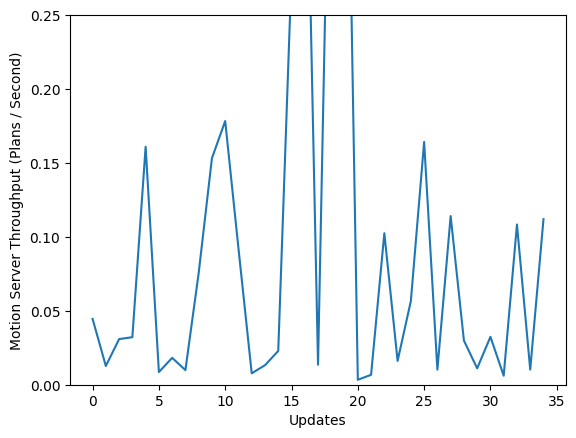

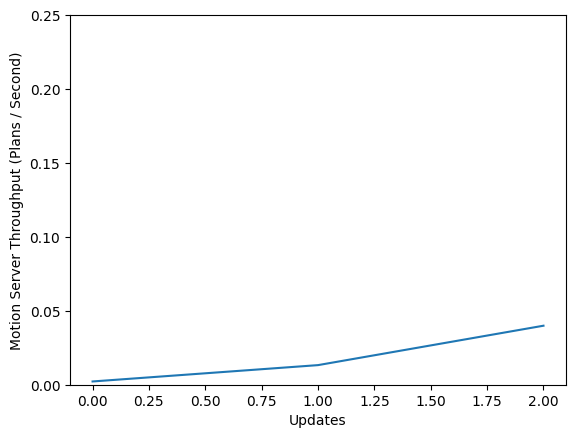

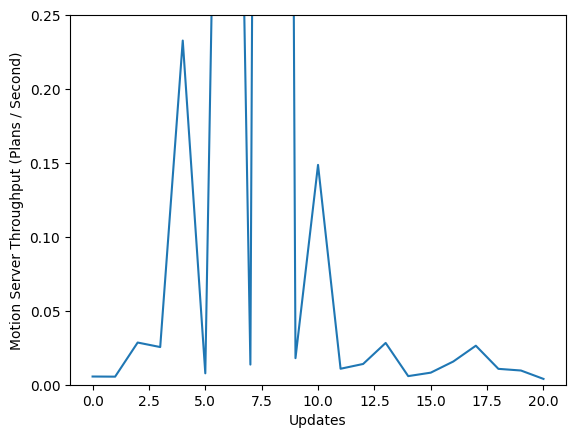

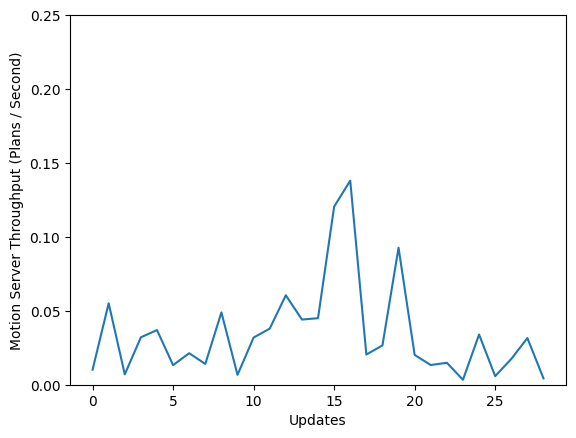

In [3]:
for motion_log in motion_logs:
    with open(motion_log) as f:
        data = f.read()

    data = data.replace("nan", "-1")
    data = data.replace("}", "},")
    data = 'var = [' + data + ']'


#     print(data)
    exec(data)
    # print(var)

#     n_plans = [a['n_plans'] if a['n_plans']>0 else 0 for a in var]
    prev_idx = 0
    curr_n_plans = 0
    
    ts = []
    avg_times = []
    
    for curr_idx in range(1, len(var)):
        if var[curr_idx]['n_plans'] > curr_n_plans:
            ts.append(var[curr_idx]['time'])
            avg_times.append((var[curr_idx]['n_plans'] - var[prev_idx]['n_plans'])/(var[curr_idx]['time'] - var[prev_idx]['time']))
            prev_idx = curr_idx
            curr_n_plans = var[curr_idx]['n_plans']
    
    plt.ylim(0,0.25)    
    plt.plot(range(len(avg_times)), avg_times)
    plt.xlabel('Updates')
    plt.ylabel('Motion Server Throughput (Plans / Second)')
    plt.show()

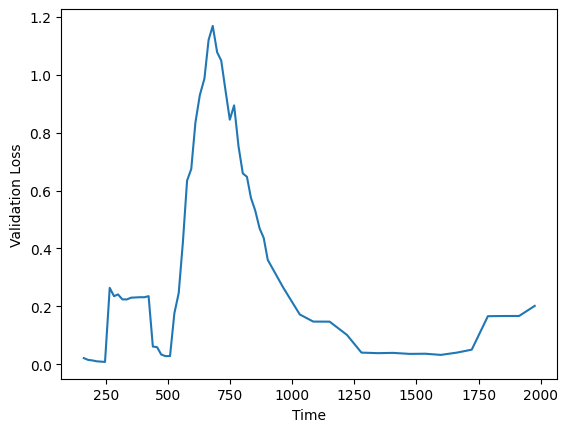

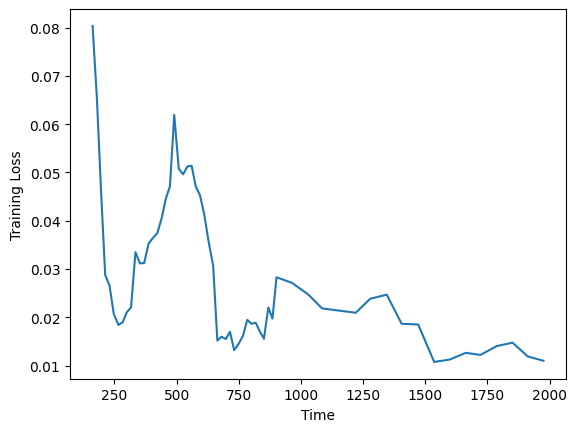

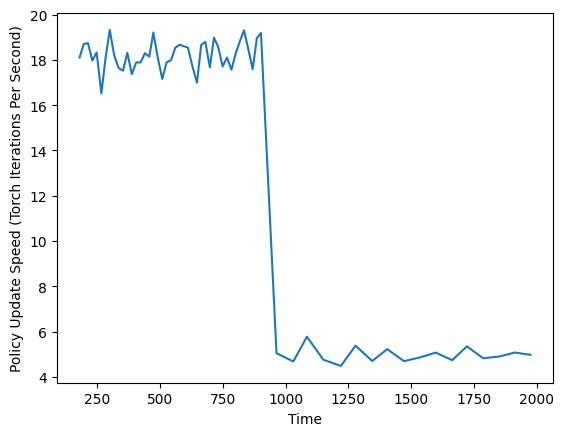

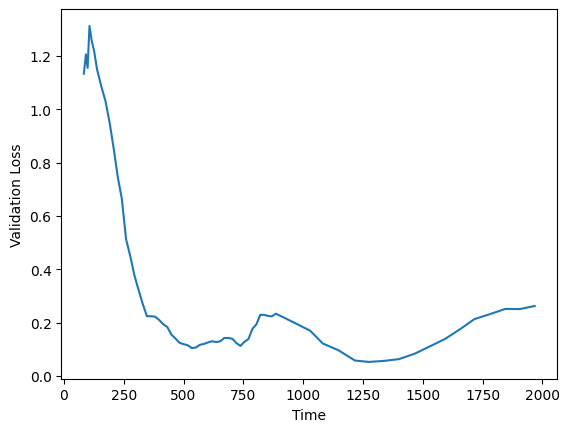

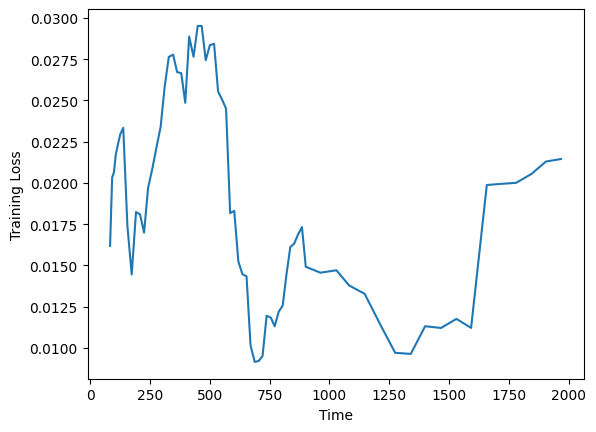

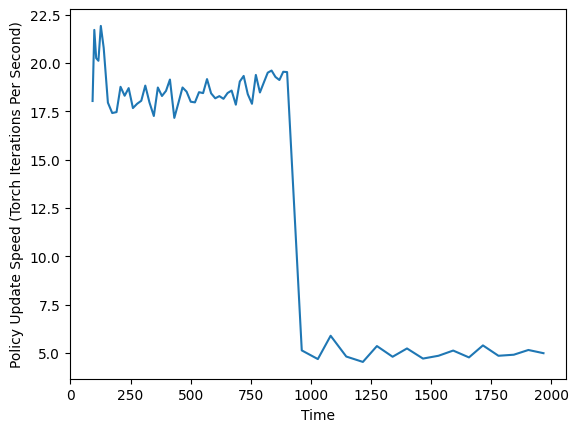

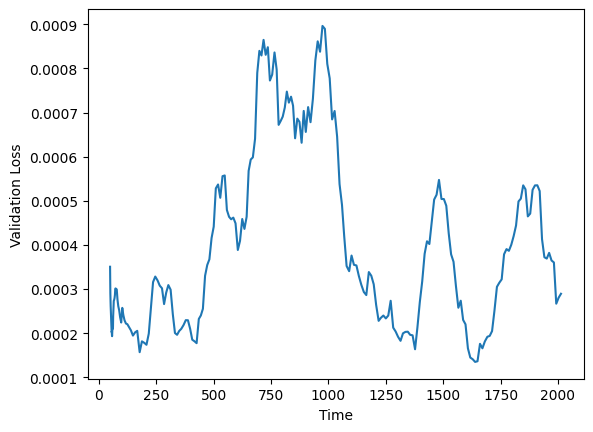

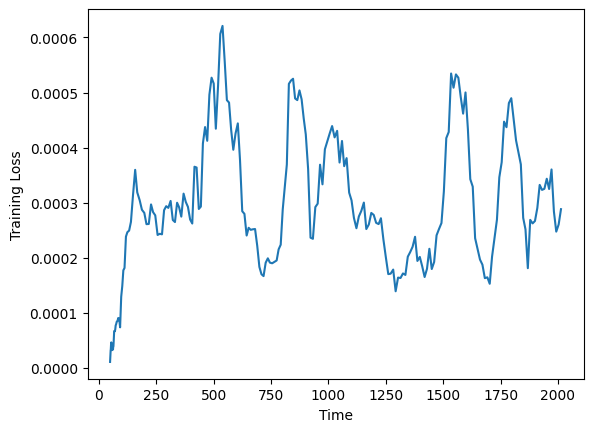

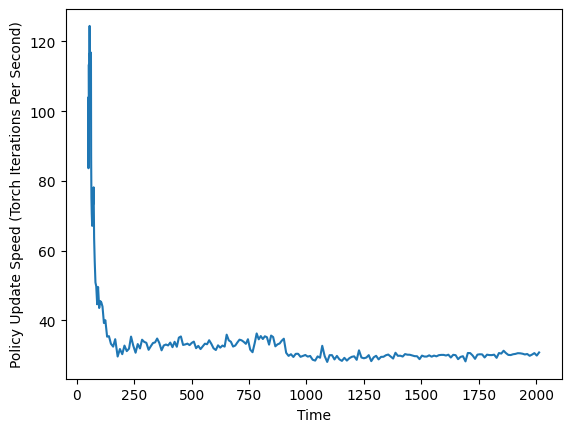

In [4]:
for policy_log in policy_logs:
    with open(policy_log) as f:
        data = f.read()

    data = data.replace("nan", "-1")
    data = data.replace("}", "},")
    data = 'var = [' + data + ']'


#     print(data)
    exec(data)
    # print(var)

    ts = [a['time'] for a in var]
    vals = [a['val_loss'] for a in var]
    plt.plot(ts, vals)
    plt.xlabel('Time')
    plt.ylabel('Validation Loss')
#     plt.ylim((0, 0.001))
    plt.show()

    ts = [a['time'] for a in var]
    vals = [a['train_loss'] for a in var]
    plt.plot(ts, vals)
    plt.xlabel('Time')
    plt.ylabel('Training Loss')
#     plt.ylim((0, 0.001))
    plt.show()

    
    prev_idx = 0
    curr_torch_iters = 0
    
    ts = []
    avg_times = []
    
    for curr_idx in range(1, len(var)):
        if var[curr_idx]['torch_iter'] > curr_torch_iters:
            ts.append(var[curr_idx]['time'])
            avg_times.append((var[curr_idx]['torch_iter'] - var[prev_idx]['torch_iter'])/(var[curr_idx]['time'] - var[prev_idx]['time']))
            curr_torch_iters = var[curr_idx]['torch_iter'] 
            prev_idx = curr_idx
    
    plt.plot(ts, avg_times)
    plt.xlabel('Time')
    plt.ylabel('Policy Update Speed (Torch Iterations Per Second)')
    plt.show()


(7, 1, 3)
(7,)


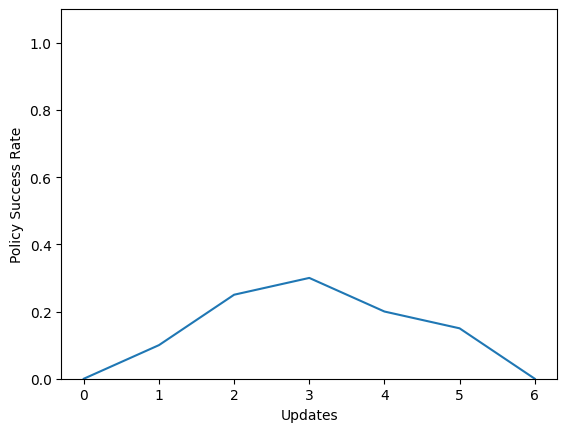

In [5]:
for rollout_test_log_link in rollout_test_logs:
    rollout_test_log = np.load(rollout_test_log_link)
    success_rates = rollout_test_log[:, 0,0 ]
    window_len = 1
    smoothed_success_rates = np.convolve(success_rates, np.ones(window_len)/window_len, mode='valid')
    print(rollout_test_log.shape)
    print(smoothed_success_rates.shape)
    plt.plot(range(rollout_test_log.shape[0]-(window_len-1)), smoothed_success_rates)
    plt.xlabel('Updates')
    plt.ylabel('Policy Success Rate')
    plt.ylim(0,1.1)
    plt.show()

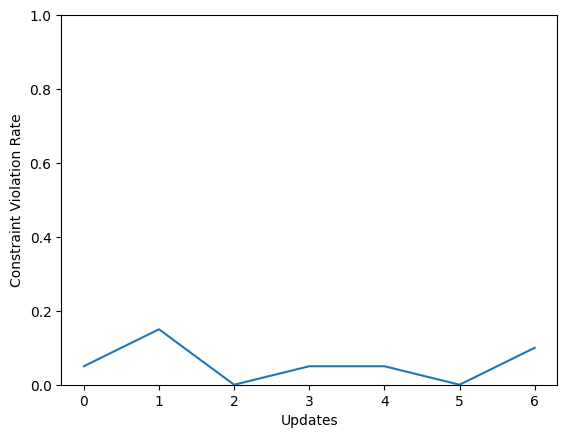

In [6]:
for rollout_test_log_link in rollout_test_logs:
    rollout_test_log = np.load(rollout_test_log_link)
    constraint_viol_rates = rollout_test_log[:, 0,1]
    window_len = 1
    smoothed_constraint_viol_rates = np.convolve(constraint_viol_rates, np.ones(window_len)/window_len, mode='valid')
    plt.plot(range(rollout_test_log.shape[0]-(window_len-1)), smoothed_constraint_viol_rates)
    plt.xlabel('Updates')
    plt.ylabel('Constraint Violation Rate')
    plt.ylim(0,1)
    plt.show()

In [7]:
import pickle

In [8]:
with open('/home/pjkc/code/openTAMP/opentamp/experiment_logs/namo_objs1_1/server_floorplan_nav_deterministic_featengineer_xycontrol_3obs_debugrollout_10write_1e0imit_0.77avoid_obscloserbutfarfromspawn_smallLIDAR_0/rollout_logs/server_test_21_verbose.pkl', 'rb') as f:
    obj = pickle.load(f)

size = len(obj)
print(size)
# for i in range(size):
traj_info = obj[i][0]

print(traj_info['obs'][:,6])
print(traj_info['aux'])

from opentamp.envs.floorplan_env import FloorplanEnvWrapper

env = FloorplanEnvWrapper()
env.position = np.array(traj_info['aux']['position'])
env.target = np.array(traj_info['aux']['target'])
env.walls = [np.array(w) for w in traj_info['aux']['walls']]
env.locations = [np.array(l) for l in traj_info['aux']['locations']]
env.obstacles = [np.array(obs) for obs in traj_info['aux']['obstacles']]
rel_vec = env.target - env.position
env.init_angle = np.arctan2(rel_vec[1], rel_vec[0])

env.reset_to_state(np.concatenate([env.position, np.array([0.])]))

imgs = [env.render()]


for a in traj_info['actions']:
    env.step(a)
    imgs.append(env.render())
import numpy as np
from PIL import Image

imgs = [Image.fromarray(img) for img in imgs]
# duration is the number of milliseconds between frames; this is 40 frames per second
imgs[0].save("array0.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)
from IPython.display import HTML
HTML('<img src="array0.gif">')


498


NameError: name 'i' is not defined

In [ ]:
i=464

In [ ]:
for i in range(size):
    print('<img src="array{}.gif">'.format(i))
    HTML('<img src="array{}.gif">'.format(i))